In [145]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from functools import reduce
%matplotlib inline

# Question 1: Propensity Score Matching

In [2]:
data = pd.read_csv('Homework4-data/lalonde.csv', dtype={
    'treat': np.bool_,
    'age': np.uint8,
    'age': np.uint8,
    'nodegree': np.bool_,
    'married': np.bool_,
    'black': np.bool_,
    'hispan': np.bool_,
    're74': np.float32,
    're75': np.float32,
    're78': np.float32
})

In [3]:
data.head()

,id,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78
0,NSW1,True,37,11,True,False,True,True,0.0,0.0,9930.045898
1,NSW2,True,22,9,False,True,False,True,0.0,0.0,3595.894043
2,NSW3,True,30,12,True,False,False,False,0.0,0.0,24909.449219
3,NSW4,True,27,11,True,False,False,True,0.0,0.0,7506.145996
4,NSW5,True,33,8,True,False,False,True,0.0,0.0,289.789886


## 1 - A naive analysis

In [4]:
treated = data.re78[data.treat == True]

In [5]:
treated.describe()

count      185.000000
mean      6349.145508
std       7867.402344
min          0.000000
25%        485.229797
50%       4232.309082
75%       9642.999023
max      60307.929688
Name: re78, dtype: float64

In [6]:
not_treated = data.re78[data.treat == False]

In [7]:
not_treated.describe()

count      429.000000
mean      6984.169434
std       7294.164551
min          0.000000
25%        220.181305
50%       4975.504883
75%      11688.820312
max      25564.669922
Name: re78, dtype: float64

In [8]:
len(range(5))

5

In [9]:
def empirical_distribution(data):
    """Computes the empirical distribution of the provided pandas series"""
    return data.value_counts().sort_index().cumsum() / len(data)

We display the earnings in 1978 using boxplots. Remark that to compare and draw conclusions, it is important to use the same scale for the two data series (`sharey='row'` and `sharex='row'`)

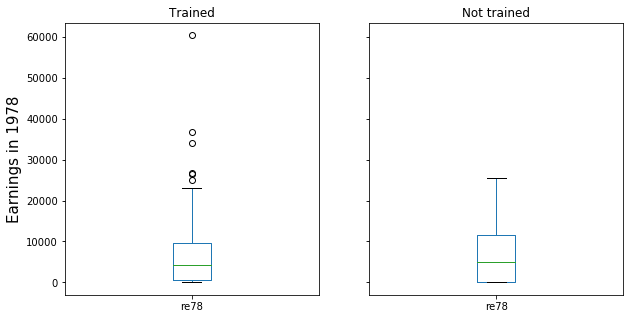

In [10]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2,
                               sharey='row', sharex='row',
                               figsize=(10, 5))

treated.plot.box(ax=ax1)
not_treated.plot.box(ax=ax2)
ax1.set_title('Trained')
ax2.set_title('Not trained')
ax1.set_ylabel('Earnings in 1978').set_size(15)

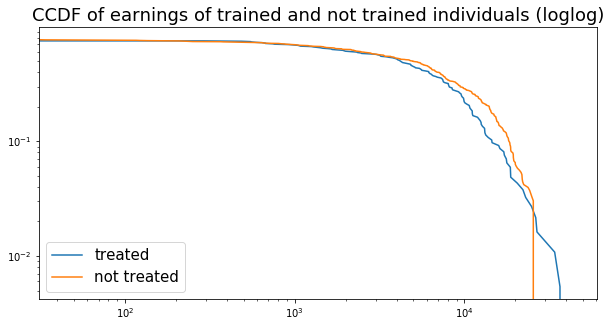

In [14]:
fig, ax = plt.subplots(figsize=(10,5))
(1 - empirical_distribution(treated)).plot(ax=ax, logx=True, logy=True)
(1 - empirical_distribution(not_treated)).plot(ax=ax)
ax.legend(['treated', 'not treated'], fontsize=15)
ax.set_title('CCDF of earnings of trained and not trained individuals (loglog)').set_size(18)

A naive researcher may conclude that, except for some outliers, the training does not make a difference in determining the earnings of the cadidates

## 2 - A closer look at the data

For each feature, we compare its distribution in the control and in the treated group.

In [75]:
def get_feature(feature_name):
    """Returns the series corresponding to feature name.
    The returned element is a tuple of two elements, the first
    corresponding to the (treated, not_treated) group"""
    get_treated = lambda treated: data[feature_name][data.treat == treated]
    return get_treated(True), get_treated(False)

### Age

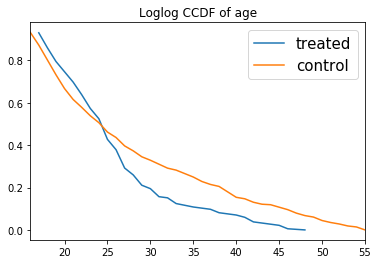

In [101]:
age_groups = get_feature('age')
for cdf in map(empirical_distribution, age_groups):
    (1 - cdf).plot()
plt.legend()
plt.legend(['treated', 'control'], fontsize=15)
plt.title('Loglog CCDF of age')

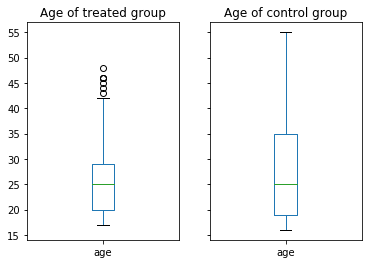

In [102]:
fig, axes = plt.subplots(nrows=1, ncols=2, sharey='row')
for ax, age_group in zip(axes, age_groups):
    age_group.plot.box(ax=ax)
axes[0].set_title('Age of treated group')
axes[1].set_title('Age of control group')

COMMENT?

### Education years

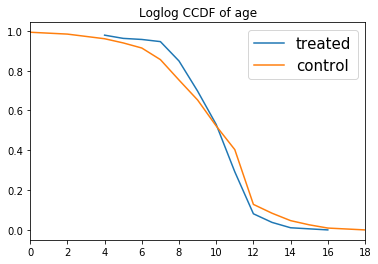

In [103]:
ed = get_feature('educ')
for cdf in map(empirical_distribution, ed):
    (1 - cdf).plot()
plt.legend()
plt.legend(['treated', 'control'], fontsize=15)
plt.title('Loglog CCDF of age')

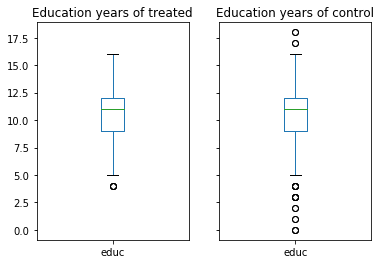

In [79]:
fig, axes = plt.subplots(nrows=1, ncols=2, sharey='row')
for ax, group in zip(axes, ed):
    group.plot.box(ax=ax)
axes[0].set_title('Education years of treated')
axes[1].set_title('Education years of control')

While the distributions of the variable in the two groups seem similar, the boxplot reveals an interesting detail: the control group has many outliers who studiend for less than the 1/4 quantile.

### Ethnicity

In [114]:
any(map(lambda tup: all(tup), data[data.hispan == data.black][['black', 'hispan']].values))

False

After having checked that there is no individual marked as both hispanic and black, we can plot the proportion of ethinicity in the the two populations:

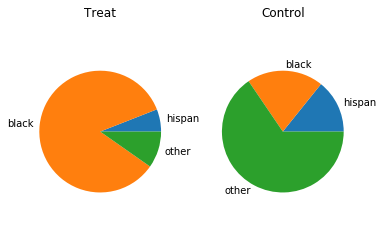

In [192]:
ethnicities = ['hispan', 'black']
fig, axes = plt.subplots(nrows=1, ncols=2)

for ax, treated in zip(axes, (True, False)):
    # Extract hispanic and black boolean indicators
    eths = data[data.treat == treated][ethnicities]
    # If neither black nor hispanic, add a True to indicate other category
    eths['other'] = reduce(lambda x, y: x & y, map(lambda e: ~eths[e], ethnicities)) # <3 mapreduce
    # Sum to obtain ethnic count
    eths = eths.sum(axis=0)
    # Plot
    ax.axis('equal')
    ax.set_title('Treat' if treated else 'Control')
    ax.pie(eths.values, labels=eths.index)

This reveals an interesting fact: the control and treated populations have very different compositions. While most of the control individuals are neither black nor hispanic (can we assume white?), most of the treated population is black.

### Civil status

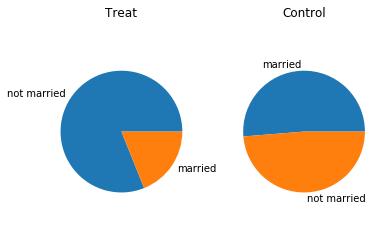

In [191]:
groups = get_feature('married')

fig, axes = plt.subplots(nrows=1, ncols=2)

for ax, g in zip(axes, groups):
    c = g.value_counts()
    ax.axis('equal')
    ax.pie(c.values, labels=['married' if t else 'not married' for t in c.index])

axes[0].set_title('Treat')
axes[1].set_title('Control')

These piecharts highlight another important difference in population composition: most of the treated individuals are not married while almost half of the control population is married.

### Degree

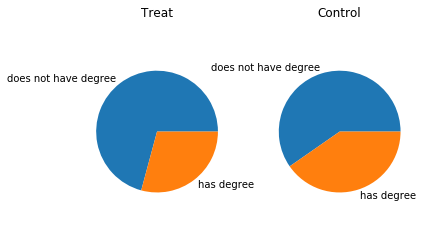

In [195]:
groups = get_feature('nodegree')

fig, axes = plt.subplots(nrows=1, ncols=2)

for ax, g in zip(axes, groups):
    c = g.value_counts()
    ax.axis('equal')
    ax.pie(c.values, labels=['does not have degree' if t else 'has degree' for t in c.index])

axes[0].set_title('Treat')
axes[1].set_title('Control')

Yet another important difference: slightly more treated individuals than controlled ones have a degree, which might directly influence their earnings

### Pre-treatment earnings

In [196]:
features = ['re74', 're75']

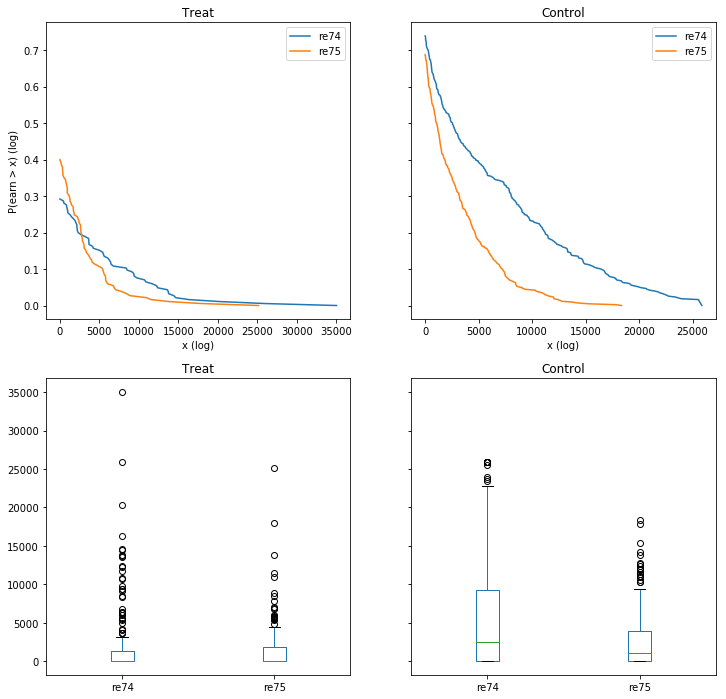

In [223]:
fig, axes = plt.subplots(nrows=2, ncols=2, sharey='row', figsize=(12, 12))

for column, treated in zip(axes.T, (True, False)):
    earnings = data[data.treat == treated][features]
    row1, row2 = column
    for year in features:
        row1.plot(1 - empirical_distribution(earnings[year]))
        row1.set_xlabel('x (log)')
        row1.set_ylabel('P(earn > x) (log)')
        row1.legend()
    earnings.plot.box(ax=row2)
    # Plot
    row1.set_title('Treat' if treated else 'Control')
    row2.set_title('Treat' if treated else 'Control')    

We observe that the control population had higher earnings than the treated population before the treatment (except some outliers)